### GOALS
- How many visibility windows per day?
- How long are they?
- What's the average gap between 2 visibility windows?
- Are visibility windows the same length as communication windows ? (maybe, some communication windows can be missed)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import MaxNLocator
import astropy.units as u

### Import data

In [28]:
vis_file = "../../results/visibility.npy"
time_file = "../../results/times.npy"
mode_file = "../../results/modes.npy"

with open(vis_file, "rb") as f:
    vis = np.load(f)
with open(time_file, "rb") as f:
    times = np.load(f)
with open(mode_file, "rb") as f:
    modes = np.load(f)

vis = vis.reshape(-1)
print(vis)
print(times)
print(modes)

simulation_time = (times[-1] * u.s).to(u.day)
print(simulation_time)

[0. 0. 0. ... 0. 0. 0.]
[0.0000e+00 1.0000e+01 2.0000e+01 ... 1.7278e+05 1.7279e+05 1.7280e+05]
[0. 5. 5. ... 0. 0. 0.]
2.0 d


### Get Visibility window statistics

In [ ]:
SECONDS_PER_DAY = 86400

# Find start and end indices of visibility windows
visibility_windows = []
start_index = None

for i in range(len(vis)):
    if vis[i] == 1 and start_index is None:
        start_index = i  # Start of a visibility window
    elif vis[i] == 0 and start_index is not None:
        visibility_windows.append((start_index, i))
        start_index = None
if start_index is not None:
    visibility_windows.append((start_index, len(vis) - 1))

# Calculate duration of each visibility window
visibility_durations = []
for start, end in visibility_windows:
    duration = times[end] - times[start]  # Duration in seconds
    visibility_durations.append(duration)

# Calculate gaps between visibility windows
gaps = []
for i in range(1, len(visibility_windows)):
    prev_end = visibility_windows[i - 1][1]
    curr_start = visibility_windows[i][0]
    gap = times[curr_start] - times[prev_end]  # Gap in seconds
    gaps.append(gap)

# Count visibility windows per day
visibility_per_day = defaultdict(int)
for start, _ in visibility_windows:
    day = times[start] // SECONDS_PER_DAY
    visibility_per_day[day] += 1

In [ ]:
# Display results
print("Visibility Durations:", visibility_durations)
print("Gaps Between Windows:", gaps)
print("Visibility Windows per Day:", dict(visibility_per_day))

Visibility Durations: [310.0, 260.0, 320.0, 260.0, 280.00000000001455, 300.00000000001455, 290.0, 290.0]
Gaps Between Windows: [5390.0, 41270.0, 5380.0, 32850.0, 5379.999999999971, 41270.0, 5380.0]
Visibility Windows per Day: {0.0: 4, 1.0: 4}


Average Visibility Duration: 288.75000000000364 seconds
Average Gap Between Windows: 5.433333333333332 hours
Average Number of Windows Per Day: 4.0


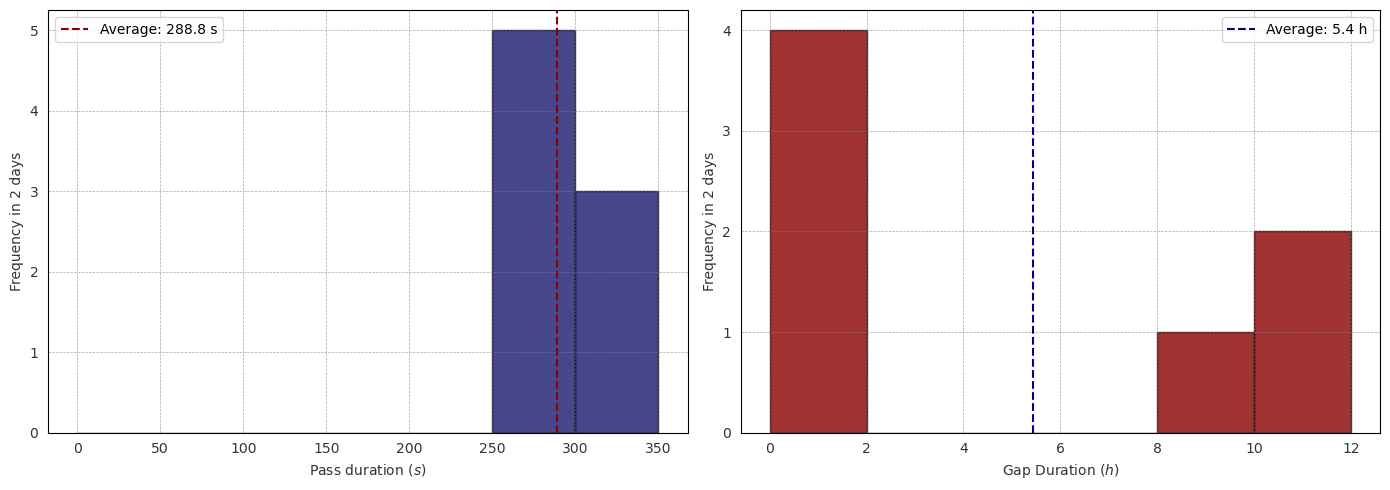

In [37]:
gaps_in_hours = np.array(gaps) / 3600  # Convert gaps from seconds to hours

# Calculate averages
avg_visibility_duration = np.mean(visibility_durations)
avg_gap = np.mean(gaps_in_hours)
avg_windows_per_day = np.mean(list(visibility_per_day.values()))

# Print calculated averages
print("Average Visibility Duration:", avg_visibility_duration, "seconds")
print("Average Gap Between Windows:", avg_gap, "hours")
print("Average Number of Windows Per Day:", avg_windows_per_day)

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Custom bins
visibility_duration_bins = np.arange(
    0, max(visibility_durations) + 50, 50
)  # Every 50 seconds
gaps_bins = np.arange(0, max(gaps_in_hours) + 2, 2)  # Every 2 hours

# Set white background and add grey dashed grid lines
fig.patch.set_facecolor("white")
for ax in [ax1, ax2]:
    ax.set_facecolor("white")
    ax.grid(
        color="grey", linestyle="--", linewidth=0.5, alpha=0.7
    )  # Grey dashed grid lines

# Plot histogram for visibility durations (dark blue)
ax1.hist(
    visibility_durations,
    bins=visibility_duration_bins,
    color="midnightblue",
    edgecolor="black",
    alpha=0.8,
)
ax1.axvline(
    avg_visibility_duration,
    color="darkred",
    linestyle="dashed",
    linewidth=1.5,
    label=f"Average: {avg_visibility_duration:.1f} s",
)
ax1.set_xlabel(r"Pass duration ($s$)", color=(0.2, 0.2, 0.2))
ax1.set_ylabel(f"Frequency in {int(simulation_time.value)} days", color=(0.2, 0.2, 0.2))
ax1.legend()
ax1.yaxis.set_ticks_position("none")
ax1.xaxis.set_ticks_position("none")
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.tick_params(axis="x", colors=(0.2, 0.2, 0.2))
ax1.tick_params(axis="y", colors=(0.2, 0.2, 0.2))

ax2.hist(gaps_in_hours, bins=gaps_bins, color="darkred", edgecolor="black", alpha=0.8)
ax2.axvline(
    avg_gap,
    color="darkblue",
    linestyle="dashed",
    linewidth=1.5,
    label=f"Average: {avg_gap:.1f} h",
)
ax2.set_xlabel(r"Gap Duration ($h$)", color=(0.2, 0.2, 0.2))
ax2.set_ylabel(f"Frequency in {int(simulation_time.value)} days", color=(0.2, 0.2, 0.2))
ax2.legend()
ax2.yaxis.set_ticks_position("none")
ax2.xaxis.set_ticks_position("none")
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.tick_params(axis="x", colors=(0.2, 0.2, 0.2))  # Dark grey in RGB
ax2.tick_params(axis="y", colors=(0.2, 0.2, 0.2))  # Dark grey in RGB

# Tight layout and display the plot
plt.tight_layout()
plt.savefig("telecom_results/histograms_1.png", dpi=300)
plt.show()

### Get windows for operating modes (similarly to visibility windows calculated above)

In [ ]:
mode_windows = {mode: [] for mode in range(6)}
start_index = None
current_mode = None

for i in range(len(modes)):
    mode = modes[i]

    # When a new mode window starts (including mode 0)
    if mode != current_mode and start_index is None:
        start_index = i
        current_mode = mode

    # When the mode changes, close the previous window and start a new one
    elif mode != current_mode and start_index is not None:
        mode_windows[current_mode].append((start_index, i))
        start_index = i  # Starting the new window
        current_mode = mode

if start_index is not None:  # last window
    mode_windows[current_mode].append((start_index, len(modes) - 1))

# Calculate the duration of each mode window
mode_durations = {mode: [] for mode in range(6)}
for mode in range(6):
    for start, end in mode_windows[mode]:
        duration = times[end] - times[start]  # Duration in seconds
        mode_durations[mode].append(duration)

In [41]:
print(mode_durations)

# Check if the sum of all mode durations matches the total time
total_mode_duration = sum(sum(mode_durations[mode]) for mode in range(6))
total_time = times[-1] - times[0]
print(f"Total duration from mode windows: {total_mode_duration} seconds")
print(f"Total time (from times array): {total_time} seconds")

{0: [10.0, 420.0, 1240.0, 8700.0, 5390.0, 41270.0, 5380.0, 9650.000000000015, 39.99999999998545, 1230.0, 8770.0, 5379.999999999971, 41270.0, 5380.0, 10000.0], 1: [], 2: [1640.0, 1000.0, 1649.9999999999854, 950.0000000000146], 3: [9.999999999996362, 179.99999999999636, 260.0, 320.0, 260.0, 10.0, 150.00000000001455, 300.00000000001455, 290.0, 290.0], 4: [120.00000000000728, 120.0], 5: [10560.0, 10560.0]}
Total duration from mode windows: 172800.0 seconds
Total time (from times array): 172800.0 seconds


### Check if any communication window is missed
As defined in the constants.py file:
- 0: IDLE
- 1: SAFE
- 2: CHARGING
- 3: UHF_COM
- 4: X_BAND_COM
- 5: MEASUREMENT

In [ ]:
print(sum(visibility_durations))
print(
    sum(mode_durations[3]) + sum(mode_durations[4])
)  # sum time spend in UHF-COM and X-BAND DOWNLINK (modes 3 and 4)


uhf_windows = mode_durations[3]
x_band_windows = mode_durations[4]
communication_windows = np.concatenate((uhf_windows, x_band_windows))
print(communication_windows)

2310.000000000029
2310.000000000029
[ 10. 180. 260. 320. 260.  10. 150. 300. 290. 290. 120. 120.]


In [ ]:
def histogram_time(
    array,
    length_bin,
    time_unit_str,
    path_save,
    xlabel,
    ylabel,
    color="midnightblue",
    edgecolor="black",
    color_avg="darkred",
):
    # Create figure and subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
    duration_bins = np.arange(0, max(array) + length_bin, length_bin)
    avg = np.mean(array)

    fig.patch.set_facecolor("white")
    ax1.set_facecolor("white")
    ax1.grid(color="grey", linestyle="--", linewidth=0.5, alpha=0.7)

    ax1.hist(
        array,
        bins=duration_bins,
        color=color,
        edgecolor=edgecolor,
        alpha=0.8,
    )
    ax1.axvline(
        avg,
        color=color_avg,
        linestyle="dashed",
        linewidth=1.5,
        label=f"Average: {avg_visibility_duration:.1f} {time_unit_str}",
    )
    ax1.set_xlabel(xlabel, color=(0.2, 0.2, 0.2))
    ax1.set_ylabel(ylabel, color=(0.2, 0.2, 0.2))
    ax1.legend()
    ax1.yaxis.set_ticks_position("none")
    ax1.xaxis.set_ticks_position("none")
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.tick_params(axis="x", colors=(0.2, 0.2, 0.2))
    ax1.tick_params(axis="y", colors=(0.2, 0.2, 0.2))

    # Tight layout and display the plot
    plt.tight_layout()
    plt.savefig(path_save, dpi=300)
    plt.show()

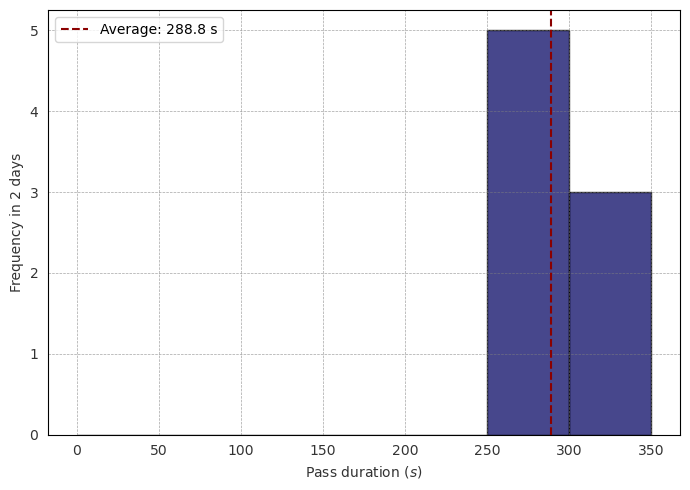

In [44]:
xlabel = r"Pass duration ($s$)"
ylabel = f"Frequency in {int(simulation_time.value)} days"
path_save = "telecom_results/histograms_new.png"
array = visibility_durations
length_bin = 50
time_unit_str = "s"

histogram_time(array, length_bin, time_unit_str, path_save, xlabel, ylabel)

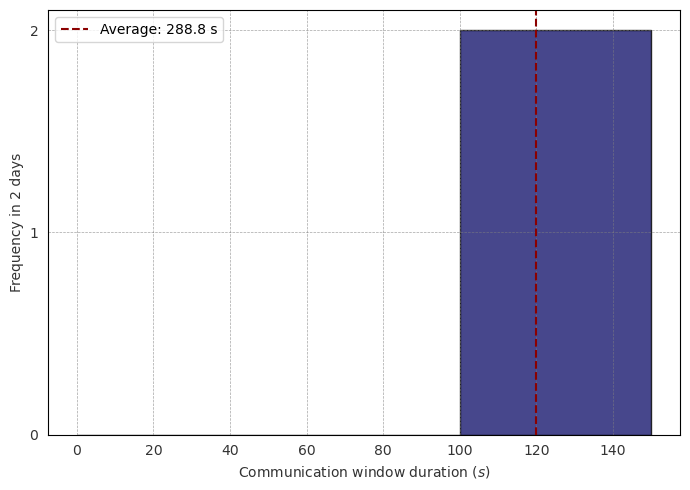

In [54]:
xlabel = r"Communication window duration ($s$)"
ylabel = f"Frequency in {int(simulation_time.value)} days"
path_save = "telecom_results/histograms_comm_window.png"
array = x_band_windows
length_bin = 50
time_unit_str = "s"

histogram_time(array, length_bin, time_unit_str, path_save, xlabel, ylabel)